Andrea Morelli 1845525 4 th Homework Big Data

In [ ]:
#the latest sklearn version is needed for the inverse of the random projection
!pip install -U scikit-learn==1.2.0

Those are the functions that allow to read the dataset , create wordcloud starting from keywords , do the elbow method both for the svd and for the k means and apply svd and k means.

In [ ]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from IPython.display import clear_output
import re
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import random_projection
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn
print(sklearn.__version__)
randomProjected=False

#read the dataset and randomly seelct part of it if you want to take just a part of it
def readDataset(percentage=0.1):
    global vectorizer
    global randomProjected
    #read X from a file
    with open('X.pickle', 'rb') as f:
        X = pickle.load(f)
    #read the vectorizer from a file
    with open('vectorizer.pickle', 'rb') as f:
        vectorizer = pickle.load(f)
    feature_names=vectorizer.get_feature_names_out(input_features=X)
    #take just a percantage of it for testing
    np.random_state=42
    rowsToRetain=int(X.shape[0]*percentage)
    X=X[np.random.choice(X.shape[0], rowsToRetain, replace=False)]
    randomProjected=False
    return X

def createWordCloud(keywords):
    # Create the wordcloud object
    wordcloud = WordCloud().generate(' '.join(keywords))
    # Display the generated wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#does the elbow method with the k means starting from min to max with step and plot the inertias for each k 
def elbowMethodMiniBatchKMeans(X,min=1,max=40,step=2,batch_size=1000):
    k=range(min,max,step)
    inertias=[]
    for i in k:
        if batch_size==0:
            km=KMeans(n_clusters=i,init='k-means++')
        else:
            km=MiniBatchKMeans(n_clusters=i,init='k-means++',batch_size=batch_size)
        km.fit(X)
        clear_output(wait=True)
        print(i,km.inertia_)
        inertias.append(km.inertia_)
        plt.plot(range(1,i+1,step),inertias,'-o')
        plt.xlabel('number of clusters, k')
        plt.ylabel('inertias')
        # plt.xticks(k[:i])
        plt.show()
        plt.clf()
        
#does the elbow method with the svd starting from min to max with step and plot the energies for each k
def elbowMethodSvd(X,min=1,max=40,step=2):
    #elbow methood on the svds
    k=range(min,max,step)
    energies=[]
    for i in k:
        svd=TruncatedSVD(n_components=i)
        svd.fit(X)
        energies.append(svd.explained_variance_ratio_.sum())
        #plot the results up to this point
        clear_output(wait=True)
        print(i,svd.explained_variance_ratio_.sum())
        plt.plot(range(1,i+1,step),energies,'-o')
        plt.xlabel('number of clusters, k')
        plt.ylabel('energy')
        # plt.xticks(k[:i])
        plt.show()
        plt.clf()

#applis the kmeans algorithm with k clusters and prints the top 20 words of each cluster, if batchsize is 0 then it uses the normal k means otherwise minibatch k means
def miniBatchKMeans(X,k=20,batch_size=1000,X_proj=None):
    global randomProjected,rp
    if batch_size==0:
        km=KMeans(n_clusters=k,init='k-means++')
    else:
        km = MiniBatchKMeans(n_clusters=k, init='k-means++',batch_size=batch_size)
    if randomProjected:
        km.fit(X_proj)
        centroids=[]
        for i in range(k):
            centroids.append(X[km.labels_==i].mean(axis=0))
        centroids=np.array(centroids)
    else:
        km.fit(X)
        centroids=km.cluster_centers_
    centroids=centroids.squeeze()
    centroids = centroids.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
    terms = vectorizer.get_feature_names_out()
    centroids=centroids.squeeze()
    for i in range(k):
        print("Cluster %d:" % i, end='')
        keywords=[]
        for ind in centroids[i, :20]:
            print(' %s' % terms[ind], end='')
            keywords.append(terms[ind])
        createWordCloud(keywords)
        print()

#applis the svd algorithm with k clusters (dimensions) and prints the top 20 words of each cluster
def truncatedSVD(X,k=20,X_proj=None):
    global randomProjected,rp
    svd = TruncatedSVD(n_components=k ,random_state=42)
    if randomProjected:
        y=svd.fit_transform(X_proj)
        components=rp.inverse_transform(svd.components_)
    else:
        y=svd.fit_transform(X)
        components=svd.components_
    print(f"Total energy retained in ratio: {svd.explained_variance_ratio_.sum()}")
    terms = vectorizer.get_feature_names_out()
    for i, comp in enumerate(svd.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20]
        print("Topic "+str(i)+": ")
        createWordCloud(i[0] for i in sorted_terms)
        s = ""
        for t in sorted_terms:
            s += t[0] + " "
        print(s)
    

connect to google drive to retrieve the preprocessed data not doing it from scratch everytime

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
%cd ../drive/My Drive/bigdatahw4

download the kaggle dataset to google drive

In [ ]:
#insert the kaggle json file in the content directory before running this cell
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

In [ ]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-books-reviews.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

read the dataset or just a portion for testing purposes

In [ ]:

percentage=1
nRows=3000001
nOfRowsToRead=int(nRows*percentage)

#read the csv text file
df = pd.read_csv('./Books_rating.csv', header=None , nrows=nOfRowsToRead)
df=df.to_numpy()

#split the data into header and data and reviews
header= df[0]
data=df[1:]
docs=data[:,-1]

print(docs.shape)

In [ ]:
#drop nan from the rows to not have problems
toDrop=[i for i,d in enumerate(docs) if type(docs[i])!=str]
docs=np.delete(docs,toDrop)

preprocess the data with tfidfVectorizer after appling lowercase, removing non alphabetic characters, removing stopwords and lemmatizing

In [ ]:
#lowercase the reviews
for i in range(len(docs)):
  docs[i] = docs[i].lower()

print("lowercase done")

#remove non alphabetic characters
for i in range(len(docs)):
  docs[i] = re.sub(r"[^a-zA-Z'\n ]", "", docs[i])

print("remove non alphabetic characters done")

#remove contractions
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

# Regular expression for finding contractions
def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

docs = [multiple_replace(contractions_dict, doc) for doc in docs] # Removing contractions

print("contractions done")

#remove \n
docs = [re.sub(r"[^a-zA-Z ]", " ", doc) for doc in docs]

#remove stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

stopwords = nltk.corpus.stopwords.words('english') # Returns a list
stopwords = set(stopwords) # We want a set, because this is implemented with a hash table
                           # Checking the if condition in rem_stop costs O(1) in this way

def rem_stop(doc):
   word_list = word_tokenize(doc)
   cleaned_doc = ""
   for word in word_list:
     if word not in stopwords:
       cleaned_doc += " " + word
   return cleaned_doc


docs = [rem_stop(doc) for doc in docs]

print("stopwords done")

#lemmatiation
lemmatizer = WordNetLemmatizer()
for i in range(len(docs)):
    word_list = word_tokenize(docs[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    docs[i] = lemmatized_doc  

print("lemmetizer done")

#tfidf vectorization
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=5) ## Corpus is in English
X = vectorizer.fit_transform(docs)

print("vectorizer done")

print(X.shape)

writes the preprocessed data to the drive

In [ ]:
# write X to a file
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)
#save the fitted vectorizer to not redo the preprocessing again
with open('vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)

use the elbow method to a portion of the dataset to find the best number of k

In [ ]:
X=readDataset(0.1)

In [ ]:
elbowMethodMiniBatchKMeans(X,1,40,2,1000)

this is the results using min 1 max 200 and step 20 with batchsize 30000 if you dont want to run the above cell
the elbow is not that clear as one can see but the inertias go down in a faster way in the first 25 inertias

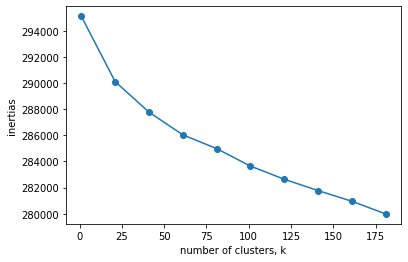

use the elbow method to a portion of the dataset to find the best number of k with random projections

In [ ]:
X=readDataset(0.1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
elbowMethodMiniBatchKMeans(X_proj,1,40,2,1000)

this is the elbow method with random projections and k means with min 1 max 200 and step 20 if you dont want to run the above cell. we can see a sort of elbow


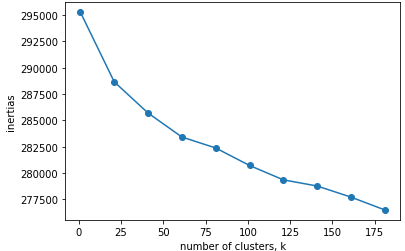

use the elbow method to a portion of the dataset to find the best k with the svd

In [ ]:
X=readDataset(0.1)

In [ ]:
elbowMethodSvd(X,1,40,2)

this the result of the elbow method with svd using min 1 max 500 and step size of 50
as you can see the the elbow is not that pronounced but the retrieved energy increases a lot in the first 50 components

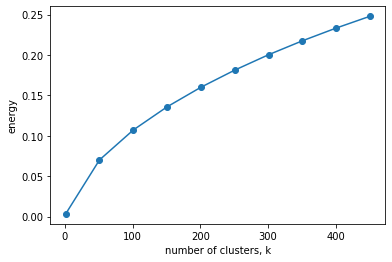

use the elbow method to a portion of the dataset to find the best k with the svd with random projections

In [ ]:
X=readDataset(0.1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
elbowMethodSvd(X_proj,1,40,2)

the result of the elbow method with svd and random projections using min 1 max 500 and step size of 50
50 percent of the energy in this case is conserved in the first 50 components. The elbow in this case is not that clear.

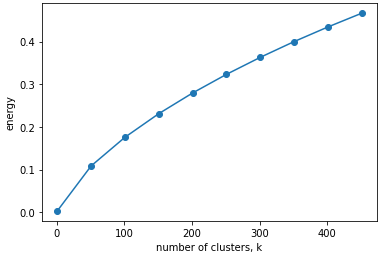

Below i will apply k means and svd on the dataset both normally or using random projections before.
The k means algorithm allows to see better clusters with clear keywords and outperforms the svd algorithm for clustering.
Below you can modify the number of clusters or components and see the results with wordclouds.

apply minibatch k means 

In [ ]:
X=readDataset(1)

In [ ]:
miniBatchKMeans(X,20,1000)

apply truncated svd

In [ ]:
X=readDataset(1)

In [ ]:
truncatedSVD(X,20)

Here you can use the random projeciton before applying the clustering algorithms. The results are not that different from the ones above in fact the k means outperforms the svd algorithm.
The performances are slightly better than the ones obtained without the random projection in the case of the k means. The performances of the svd with random projections though are worse than the ones without random projections.
I suppose that for the k means the random projection acts as a denoiser and the clusters are more clear and separated.
You can change the number of clusters i tried different numbers and with 100 i would obtain more clear keywords seeing clearly types of cluseters.
Using smaller numbers will results in more general keywords and the clusters would not be that visible.
The elbow methods were not super clear on what the number of clusters would be since there was not a pronounced elbow.

apply random projection and then k means

In [ ]:
X=readDataset(1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
miniBatchKMeans(X,20,30000,X_proj)

apply random projection and then truncated svd

In [ ]:
X=readDataset(1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
truncatedSVD(X,20,X_proj)

apply svd and then k means (results are horrible its there just because i used it and saw that nothing would come out of it)
its probabily because the svd is not able to keep most of the energy in the first components like for example in the images where most of the energy 90% is kept
at the first like 100 components.
In this case with 500 components i would retrieve only the 30% of the energy and it's not enought to cluster the data correctly

In [ ]:
X=readDataset(0.01)

In [ ]:
#apply svd to do dimensionality reduction and then k means to classify the data
newDimensions=200
k=20
batchSize=1000
svd=TruncatedSVD(n_components=newDimensions)
X=svd.fit_transform(X)
if batchSize==0:
    km=KMeans(n_clusters=k,init='k-means++')
else:
    km=MiniBatchKMeans(n_clusters=k,batch_size=batchSize,init='k-means++')
km.fit(X)
centroids=km.cluster_centers_
centroids=svd.inverse_transform(centroids).astype(int)
terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(centroids):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    createWordCloud(i[0] for i in sorted_terms)
    s = ""
    for t in sorted_terms:
        s += t[0] + " "
    print(s)


The best performances are reached using random projection and the the k means algorithm. 
The random projection acts as noise reduction reducing the dimensionality of the dataset and the k means algorithm is able to find the clusters.
Using 100 or 200 clusters we can clearly see the topics of the reviews in a fine way using less of them would allow to see more general topics like 30.
The performaces are worse if we use less components of the random projection and a smaller batch size.
Using less clusters will allow to see more general topics while using more clusters allows to see for example keywords of the reviews and the books.
Another particularity found is that using just on a portion of the dataset the clustering will allow to see more less general topics while using the whole dataset will allow to see more general topics.

In [ ]:
X=readDataset(1)

In [10]:
rp=random_projection.SparseRandomProjection(n_components=1000)
X_proj=rp.fit_transform(X)
randomProjected=True

if you want better results increase the batchsize to 500000 like the reviews i reported below

Cluster 0: instituted booker pearl washington treasure share wisdom education positive required student bought gift wish loved beautiful book thought work way

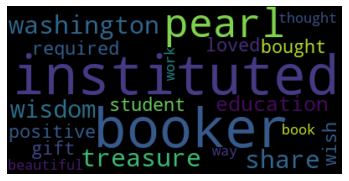


Cluster 1: thucydides war peloponnesian athens greenwood perikles political warfare athenian guide major civilisation military concluding includes expansion homer earliest section strifethe

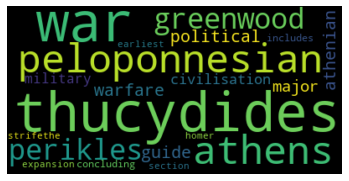


Cluster 2: cornwell patricia recommend highly book excellent finished day read reading best author enjoyed good page coroner love paterson stop mystery

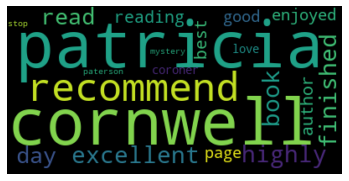


Cluster 3: harry potter hogwarts azkaban sirius rowling jk prisoner book black wizard wizardry voldemort school witchcraft read ron year series escaped

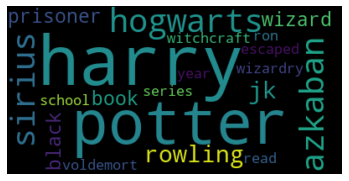


Cluster 4: bennett judgementalelizabeth oneelizabeth sister nerdy isit flighty fairness observes folly judgement headed darcy harsh written judge elizabeth reminds happiness mary

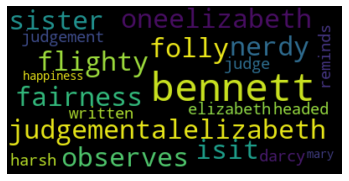


Cluster 5: account great read hand lurid history balanced happened slavery real invention groundmy cause contemporary possible mission news finally today mir

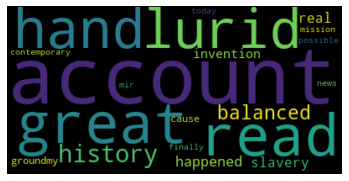


Cluster 6: jung noll intellectual antigerman kaufmann libel bunk psychology slander oblivion jungian german vile analyst nietzsche dismiss ethnic trading garbage plague

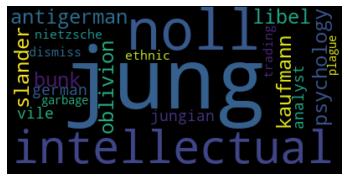


Cluster 7: tripnot blue maui deserted wasting insider priceless restaurant hotel critique vacation selling beach returned info map allowed store asked valuable

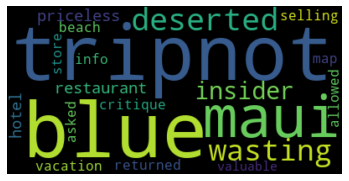


Cluster 8: sedaris france laugh family humor north story smart decides south appreciate past individual taken meet amazing look book collection midget

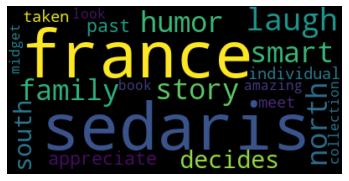


Cluster 9: triology really hobbit book ring background lord second movie good enjoy help reading read fantastic miss missed better glad understand

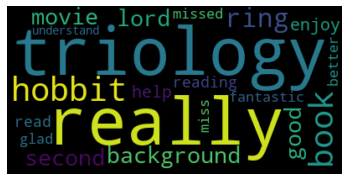


Cluster 10: elvis cole crais book pike joe fan presley story read detective life robert man character novel great ben skating series

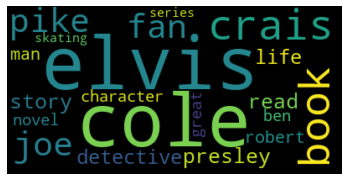


Cluster 11: trading trader book maze market day stock epic strategy trade best psychology read series satisified word fountainhood need money swing

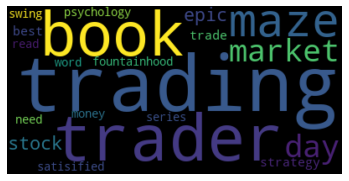


Cluster 12: timely received shape manner condition book good great arrived fashion excellent pleased purchase seller thanks ordered product thank item order

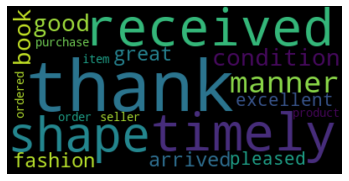


Cluster 13: software website book engineering development developer free read literature great architect project engineer testing excellent design help good understand company

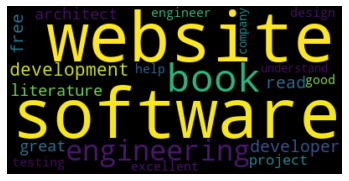


Cluster 14: sean compelling talking francisco san wilsey bit point recommend social read travail great mighty column resident interesting caught life book

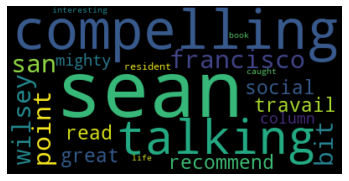


Cluster 15: pratchett terry opera favourite wax wonderful imagination weather writer like granny read written lancre great tiffany aching time book disc

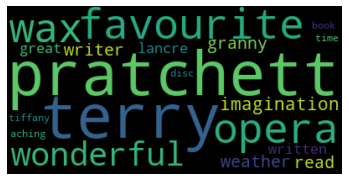


Cluster 16: really good book enjoyed like read reading think liked feel love great want story got character movie know time family

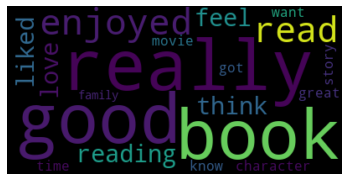


Cluster 17: shatner trek saga william seek space faith greatest edition relationship adventure star chapter excellent highly recommend know like time story

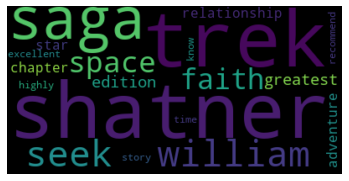


Cluster 18: loss death shorti earth answer life judgmental book drastic ross adversity lightly cherish cope grief grateful defeat dealt precious divorce

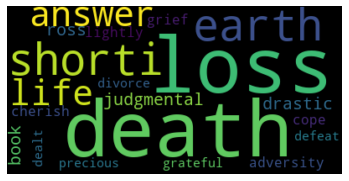


Cluster 19: anxiety worry kid child overcoming guide incorperate book purchased glad parent retrained step poster specific son bookwhat wonderful reduce understand

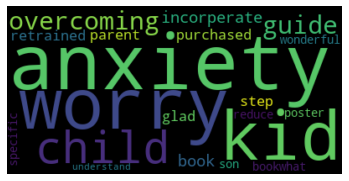


Cluster 20: lieberman quotwhy selfdefeating dr david habit behavior reader leiberman credential indentify opinion instant exempting scrutinised subject problem expert psychology nonmember

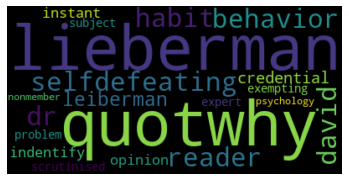


Cluster 21: eagle gauli latin mandorix yearwith familywith nevernever omni partes allyou readwith tress othersif centurion ferment slid gaul mast readeri homestead

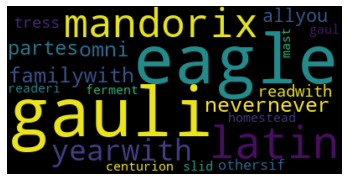


Cluster 22: woody discography listened amazing woodman raconteur hornung standup mia day comedian like think delaware maker read option kim skip hilarious

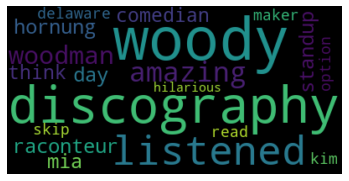


Cluster 23: xanth series anthony pier book bink magic novel read spell chameleon continuing pun source best adventure great centaur good reading

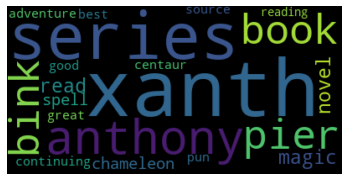


Cluster 24: asleep spcethis sared horriblethe ure walla doze hav pill lifei sleeping thats sat sum thing literally fell worst forced fast

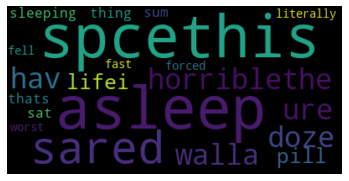


Cluster 25: forced read school reason despised tyranny mentality peace passion surprised guess recently valuable liked time glad decade book college like

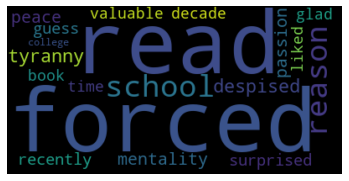


Cluster 26: worm hapkido hutton yorick sac book ineresting trump sterne marxist stover bisexual history unlikable read repcheck like donald earth dmed

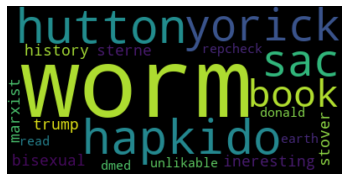


Cluster 27: nap counting sleep sheep solution baby picture little week dragon naptime book shehe important looking help upstairs picturesque boy old

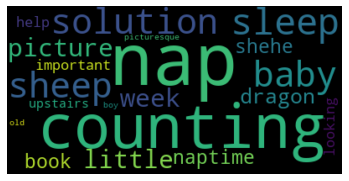


Cluster 28: science fiction scifi best read book novel love like series heinlein story written classic possibly historyand fan list think suggest

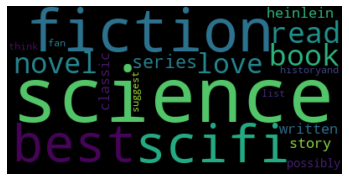


Cluster 29: strasser booki great gun club book wonderful ending plot thought read boy reader violence isso todd issue think bookthere storythis

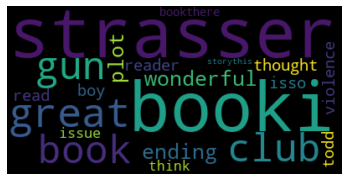


Cluster 30: guide game strategy final fantasy bos map walkthrough bestiary dungeon stats bradygames section complete secret tell boss enemy ffi helpful

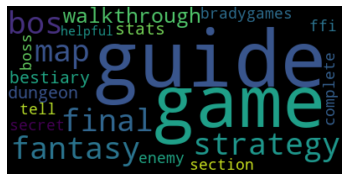


Cluster 31: horseman readingmany spookiness ichabod headless backwater story washing hudson sleepy crane halloween chock flowery irving populated detailing word look establish

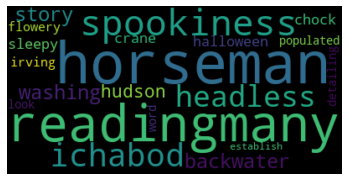


Cluster 32: reacher jack lee child series read novel book great character reading love like good movie cruise action hooked want enjoy

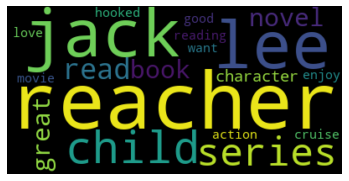


Cluster 33: azyr vocation hero kercadiou aline swordsman procession opposes villainous finally marquis nobleman successive delightfully confronted astounding backdrop blend politician revolutionary

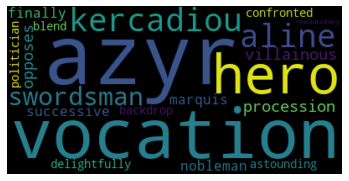


Cluster 34: damaged came book schwartz early warped advertised edge acceptable bit sun charles scissors really thanks great new remember cent page

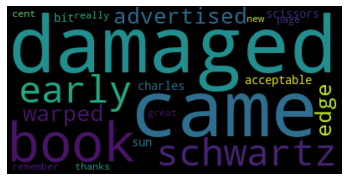


Cluster 35: publishedi scrambled courier wot mat sounded mess initially prayer cousin bound disappointment decent total asked readable pain mention book head

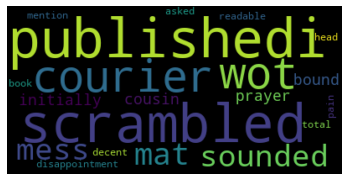


Cluster 36: relates missing insight hancock real world hypothesis lot crisp graham good refuse book accept decide life usual collection follow clear

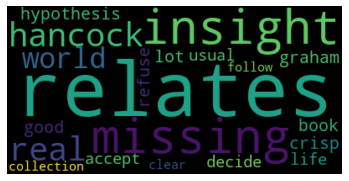


Cluster 37: lamott anne faith book god read life christian honest like love bird people humor mother mattie writing funny real son

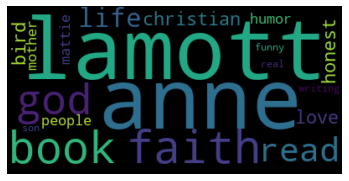


Cluster 38: gratest writen yestirday leter speling meby gatz scot praising catcher ben think wrote wish book say best gameender gamechapter gamechanger

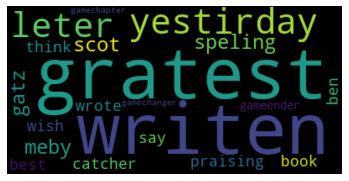


Cluster 39: time enjoyable written read elegant frankly older certain stop follow difficult took style chapter book interesting little know reading gamecock

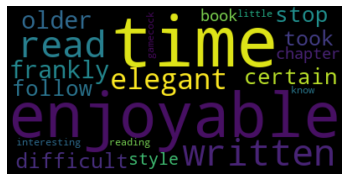


Cluster 40: deprecating particularily hampered parkinson persevere commendable gratitude rooted celebrity fox extended heroic proud ground solid seriously career manner self stay

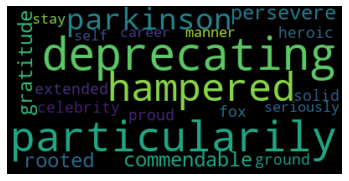


Cluster 41: author faith book wait great read bravo love really character perserverance present enjoyed interesting restored time like kid wonderful peltier

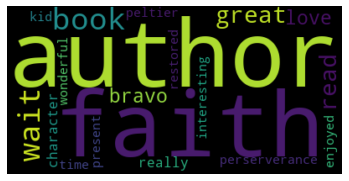


Cluster 42: club finished book hard okay extremely good selection finish classic discussion picked recommend member lead read need liked question great

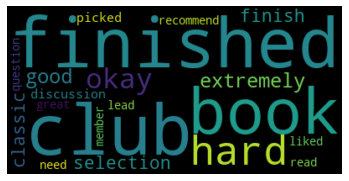


Cluster 43: sartre existentialism philosophy essay work quotirrational jeanpaul god nothingness idea uneccessary marcel understandable barrett different ethic metaphysics manquot stressed understand

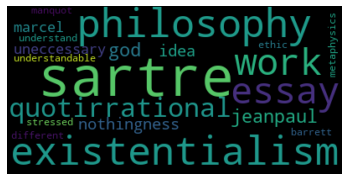


Cluster 44: deana lorgin amp castif lorgan romantic stong goosebump sex romance want world dumb sexy mention mood utterly interaction alien earth

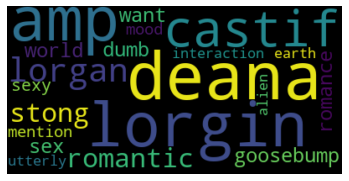


Cluster 45: austen jane auster cafeacute leviathan intending endi exhilarating dancing nearby dialog marvelous storytelling bookstore book match gotten paul door caught

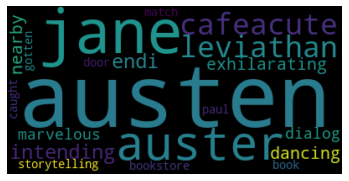


Cluster 46: jonas job community memory receiver giver assigned boy book named color receives good giverthe life training little gabriel receive girl

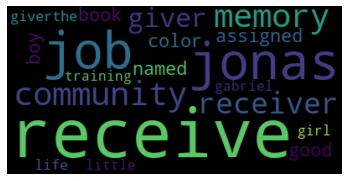


Cluster 47: awesome book read great love recommend loved best series wait movie favorite like want good really reading say little story

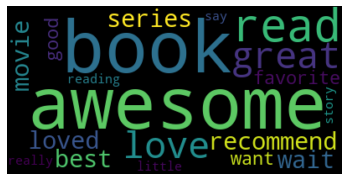


Cluster 48: pimp iceberg parody pop slims criminal dogg good theyi juans myspace factly pimping scumbag snoop deceiver minstrel amazon book white

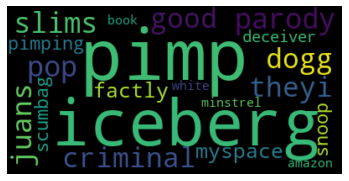


Cluster 49: loved book read love reading great story kindle time movie year recommend classic really good child character like bought absolutely

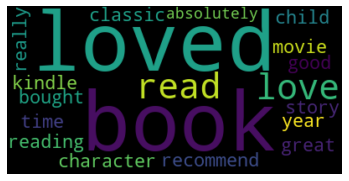


Cluster 50: radiology chest radiologist wellused specialize student med differential anticipate information looking diagnosis book ambitious resident satisfied straightforward logical medical written

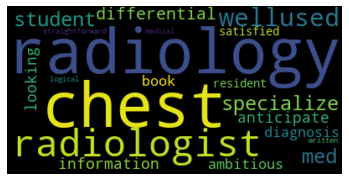


Cluster 51: cherokee chickamauga method donovancalifornia bookwatch literary collegelevel interpreting analyzing survives engagement composed resistance different nuance daniel storm revealing consciousness beloved

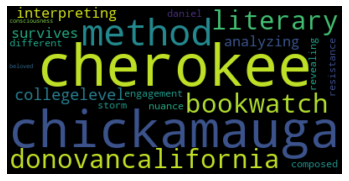


Cluster 52: alphbetical teama fing topic backup scriptural aid encourage talking purchased quick possible guide situation entire order copy help people gamecube

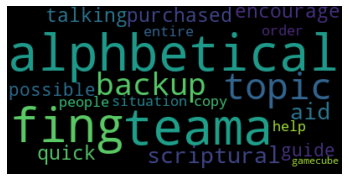


Cluster 53: written little good story herothe backbone impatient breeze representing engrossed trapped wishing fascinated china appreciated sweet predictable weak cultural taste

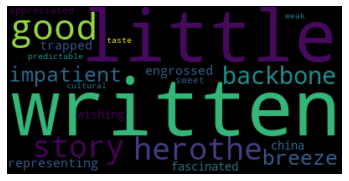


Cluster 54: book read story great time like good reading character love life really novel make year way author people think know

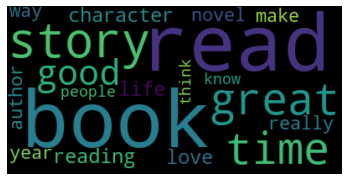


Cluster 55: rukmani nathan kuti firecracker sieve impregnable monsoon land village son ira life recognitionand household lifequoti meal quailed arjun complaisant kennington

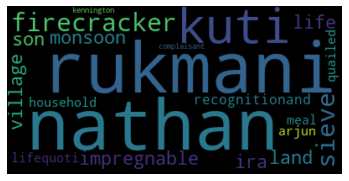


Cluster 56: hate soon really book cassandra report castle love reading started cute hooked cool caught finished turned say month thought sister

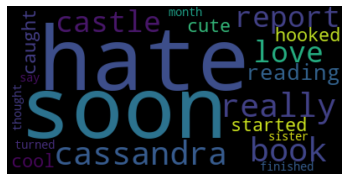


Cluster 57: ltggt laugh alec anthony kate holmes delightful george return hero future hope kind say love really make book like gamebefore

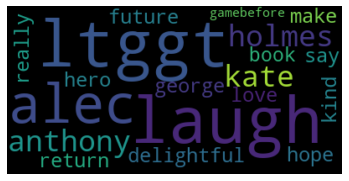


Cluster 58: terrific beach playa read half carmen parisian honeymoon del transition vacation laughing memorable loud childhood humor enjoyable story deal second

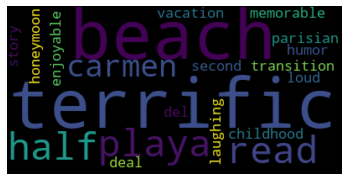


Cluster 59: river book twain history journey time mississippi people phoenix day sheer tributary civil god mark present read like wonderful period

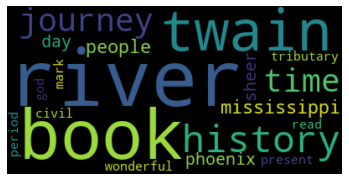


Cluster 60: wonder really future longer make wish different book good happen read way work great long best summery time pretties booksthe

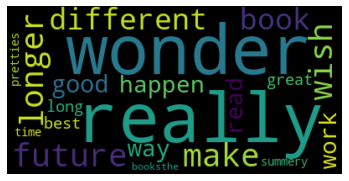


Cluster 61: waldron mozart research ebook expect wa intensive gratuitous grammatical stating selected comprehend healthy fail apparent novel biography fair error intriguing

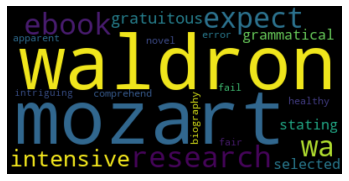


Cluster 62: learn telllot themegood classwhat thing need knowi mockingbird write english sin importance kill moral good agree evil social year bad

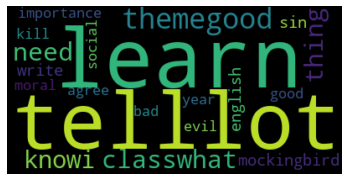


Cluster 63: download file access pharm audio day ipod bible couple complete completely wasting ago hope closed bothered phone holiday fail office

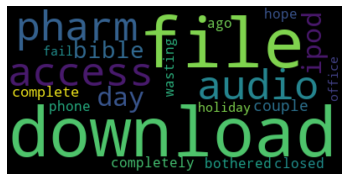


Cluster 64: precious sapphire push life father jones mother abused illiteracy school abuse claireece book illiterate child rain story novel reading read

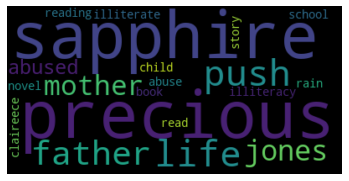


Cluster 65: cooking delicous weeping tita hungry reccomend recipe magic kept romance love great book gameday gamechangers gamebygame gamechanger gamefaqscom gamefaqs gamechangercrime

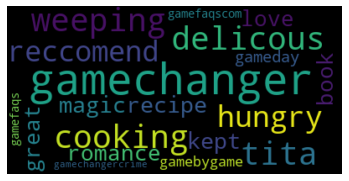


Cluster 66: kid read book class remember got reading little enjoyed cute great love really like favorite plan blatently absolutely adult good

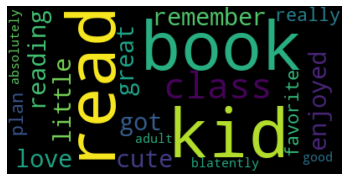


Cluster 67: source assertion pictureit discrediting author againthe contradicts variable interrupted tangent information dictate verbose knowledgeable clearer contribute credible history meaningless gather

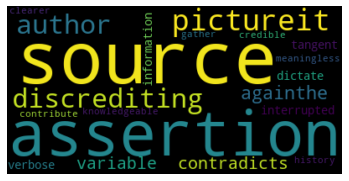


Cluster 68: equation approximated scattering singularity using derivation enabled electric integral stepbystep exact expression solve code cross solution relevant error check field

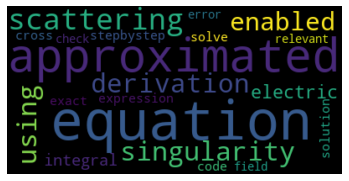


Cluster 69: bukowski yuck kriegel chiasmus campground beat edgey ne poetry napkin disagreed mo posthumously unread boring said chuck book colorful rhetoric

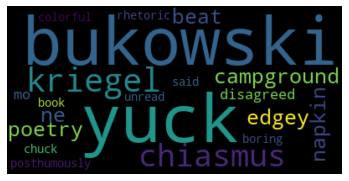


Cluster 70: billed received ordered ordering book watership cover stop entire itwhat instead awaiting typically mouth chapter recommendation glued epic sticker october

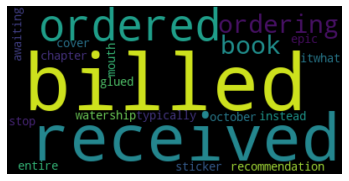


Cluster 71: classic kidsit educator convoluted lower intelligence seriously terrible grade high school force certain boring called believe book read dickens reread

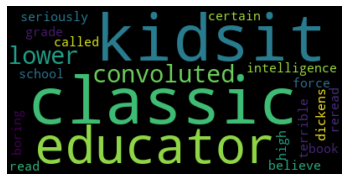


Cluster 72: leigh henshaw mr botts dear dad letter lunch book cleary divorced author mrhenshaw beverly parent writes boy mom writing favorite

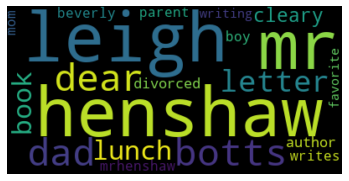


Cluster 73: lizzie settle darcy mr bingley bennett love drag concerning tired elizabeth journey reading drama romance taught getting jane bring middle

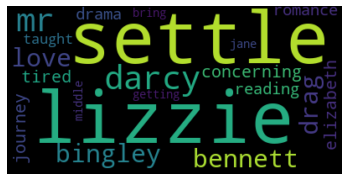


Cluster 74: cornering scooter game magazine brady look scotter handeling moped mabey malibu carefull slow rampage wrong stunt stats vice like package

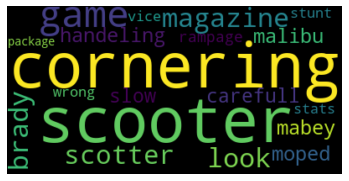


Cluster 75: bebasically work book encompass pardon clicheacute great fluid defines aftermath rebellion representation capitalism communism wrapped mirror soviet mouth fairy dynamic

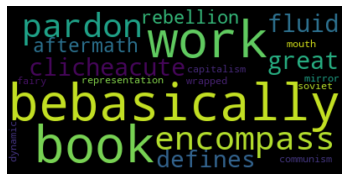


Cluster 76: pull great really book story read unsolvable love feel right person know bennet leading distance successfully wonderful austen humanity discover

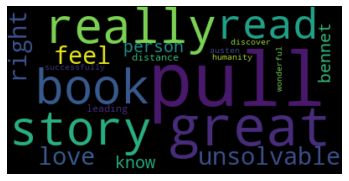


Cluster 77: threw young read girl book hope diary birthdayi like going war overthe bookthere readthis love gave text used till printed

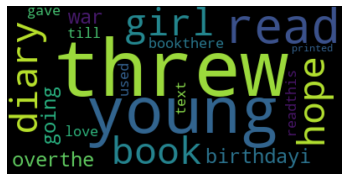


Cluster 78: trust pseudomoral employee habit themhere stockholder maneuvered etcand guy parachute covey unemployment clown guise generate manipulate enable fuel stalin societal

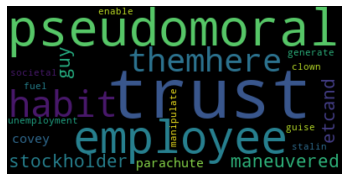


Cluster 79: superlative superfluous experienceyou testosterone drowns sappy phenomenal stomach portrays endless hint dramatic descriptive love drama possibly sea prose basic lead

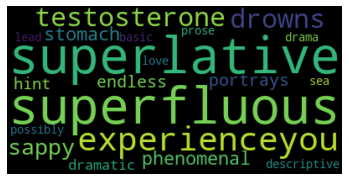


Cluster 80: intro helped agnes endthe emerges grey penguin entertained wuthering eyre finishing height focused unable anne dry gain life jane sister

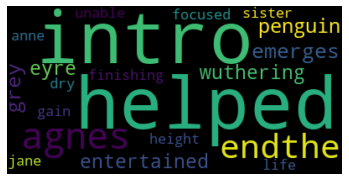


Cluster 81: holden teenager extremeness represent wryness quotphoniesquot outdone simply manhood critically caulfield acclaimed alright jd realistically prep ripped salinger stereotype rough

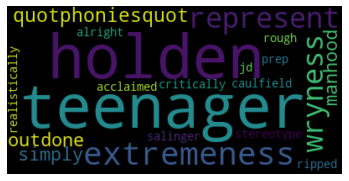


Cluster 82: proof listenquoti lassezfaire tiddly quotlacking qualitiesquot rand capitalismquot philosophical karamazovquot quotscientific plotquot quotthe umberto wink eco literature enriching quotno conceive

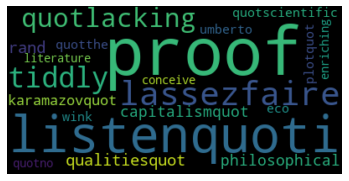


Cluster 83: church mussolini unbiased editorial misleading furthermore ought bias motif logic correct ii terrible accurate worst usually book account future opinion

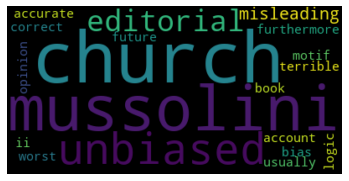


Cluster 84: drosophila layman fly scientific genetics research fruit pocketsize journal scientist hidden incomparably content specious quality telling seedy colloquial resorting breezy

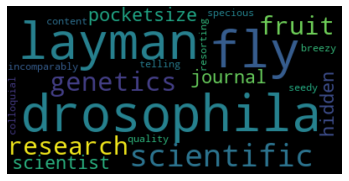


Cluster 85: bible study kjv read book great easy reading recommend understand version love amplified word new wonderful niv help use god

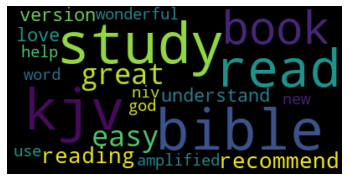


Cluster 86: guitar playing music book learn theory advancedi teach play heartbreakingly player change gaze photo played learning choice great teacher andy

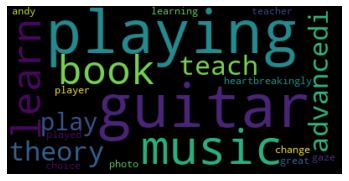


Cluster 87: legend lovescenes gerold savour overstated historical compromising donna pm ninth joan wellresearched agreement pope story flesh feminist tendency straight contemporary

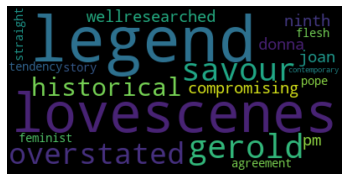


Cluster 88: courageto aquarist ihad aquarium tank marine worn novice proud inspired continues great bible dream month learned gave deal subject question

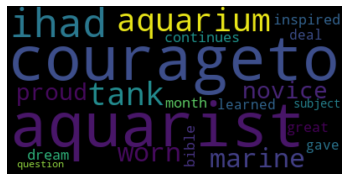


Cluster 89: oppression puritan scarlet readmoreover letter era inhumane undergoing description today rigid nathaniel socially delf stark hawthorne applies boston reminder stronger

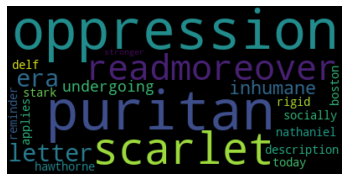


Cluster 90: koren drinking himselfthomas alcohol quottreasure ei drink islandquot smashed college girl behaved zailckas inn book story pirate alcoholic parent served

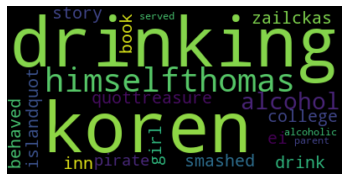


Cluster 91: nice book read highres wanted locost whyall starttofinish materialsthe build quality high howto interesting primarily biggest overview publisher photo product

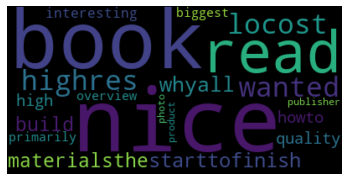


Cluster 92: center earth journey book second favorite jules verne iceland read mountain fact discovery sneffels related finish ascend science descend fatigue

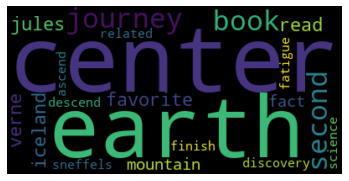


Cluster 93: tesshu calligrapher stipend shinto retainer feudalism poor account industrialized samurai preferring crumbling innumerable devout starvation starving homeless martial great buddhist

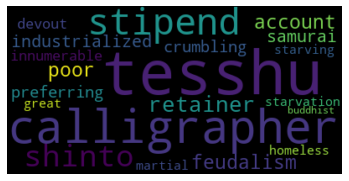


Cluster 94: casebook law case liked explanation class daughter criminal professor supplement chemerinsky yeazell note book mpc dressler use help brief step

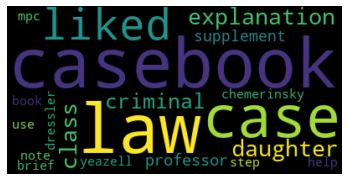


Cluster 95: homework available textbook problem needed son home school help chapter pearson half static course set used select instructor mechanic representative

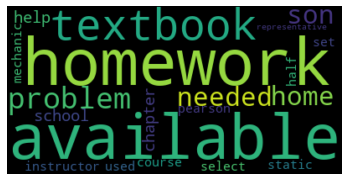


Cluster 96: origami model folding book animal fold montroll folder make best design like enthusiast beginner simple flower zebra great creation project

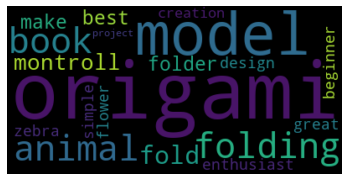


Cluster 97: fluenz course cd lesson excercises pimsleur learner pronunciation tourist accompanied considerable suitable grammar vocabulary cultural benefit plenty spend tool expect

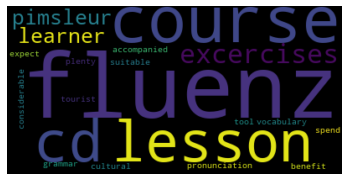


Cluster 98: hated lois duncan flashback book absolutely school movie finish read check great recommend good twin series author different end talented

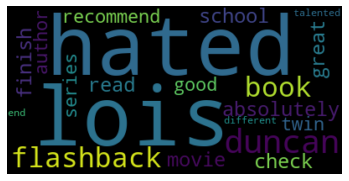


Cluster 99: information useful book actually applicant entertaining lot potential date think new tomlin gardening rereading reference best read money chapter want

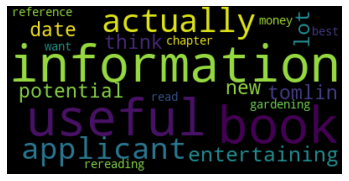

In [12]:
miniBatchKMeans(X,100,500000,X_proj)

In case you dont want to execute the code i will include the clus.ters found with just the keywords if you want the wordcloud run the above cells. the keywords are from most to less important.
i will write the name of the topics if i can distinguish them for the 200 clusters.
The first like 4 keywords of each cluster determine the topic of the cluster.


Cluster 0: okay eater picky book wording want priced mar month storyline read good setting fussy overall encouraging motivated great wtheir old


Cluster 1: cowboy giftsit burl alonequot ives mustang greet quotnot wyoming evoking feeling make person richer photography listened additional amp cd poetry

transports
Cluster 2: itd rd loved diesel locomotive submariner fever husband captain darkfever veteran series controller traffic father book stop day air sick

state of the delivered book
Cluster 3: condition thank speedy arrived great delivery book perfect excellent service came described shipping time good quickly price pleased stated fast

referring to movies
Cluster 4: movie watch book wonderful read going saw mental reading generationsenjoyed te think recent time love carch enjoyed helped better word

adventure book
Cluster 5: courage book predicted great faith predictable lot mccain man resilience story pg couragethe happened adventure stand pretty good defend thing

reccommented book
Cluster 6: definitely recommend book read virtue faith teach love best amazing great loved easy hard follow fun knuth illistrated seller expected

tolkien book
Cluster 7: ring lord hobbit read bilbo frodo book tolkien fellowship trilogy baggins adventure sauron fantasy great reading movie story destroy good

science book
Cluster 8: heinlein th grade kept science finest fiction robert mind deepest blown shorter mixed reading report philosophical originally choose religious presented

virginia woolf like book
Cluster 9: woolf virginia woman fiction orlando read writer novel book writing dalloway genius room work lighthouse life feminist reader like female


Cluster 10: greg camera book shari bear story read iles grace life love friend school good basketball rena jill like really great

philosophy book
Cluster 11: rand moral philosophy motive ayn absoluteyou victimtake onedimensioned notread discover achievment purpose term sanction power live productive invention intend point

twilight book
Cluster 12: twilight journal story whisk repelled romance bram stoker feeling dracula dread character excellent enjoyed grim read gothic rated achieved successfully


Cluster 13: preforeclosures preforeclosure thomas lucier getrichquick step supplying personable telephone easy investing coach scheme email stress virtually risk sell lay paint


Cluster 14: democrat stara fireif ferried footstep enjoy kerry senator liar flew hostile photographer gore regularly observer johnson silver proven combat al


Cluster 15: art buy text security teacher equity investing best performance year low market book selfserving invested easy distraction read predict precise

education book
Cluster 16: goodkind khalan possessor richie rahl confessor ire galt connecting lifei mentality collective shrugged terry royal atlas ayn sword thread influenced

training dog
Cluster 17: dog housetrained housetraining clicker crate vigilant confine incessantly pup getting interval neurotic darling catastrophe puppy signal nonstop controlled connect physically


Cluster 18: fielding bang know suspenseful pageif memory turned drugged amnesia stressful fun psychologist sink disorder enthralled staff pocket boston disappoint afternoon

irish book
Cluster 19: irish ireland history book study literature mythology murder fairy american social appreciate people read bot america learned fan descent cornish


Cluster 20: ejd book best francie life feltthroughout friend sad read obsticles think connected win talk like better mean hilton influence daily

condition of the book and the delivery
Cluster 21: seller condition buy came book great good quickly arrived definitely time perfect stated product happy expected recommend excellent item promised


Cluster 22: jeff resnick book read buckley bradley brother good story like mystery tim great music life friend character new watie want


Cluster 23: souled play excessively ol output recognizable melodramatic shake flesh department consistent viewpoint shallow essentially queen affair blood drama waste single


Cluster 24: shaara gettysburg book character rebellion glorious battle historical fiction rise war history leading writing cause soldier men novel eisenhower start

thriller
Cluster 25: thrill charactersevery beautyit mountain greenery pulsating sizzling romance coastal sunshine methe fuller lush continuous richer intensely kiss exquisite paradise exotic


Cluster 26: freak max mighty rodman book kevin philbrick friend kane kid like boy read killer really think dad smart good adventure


Cluster 27: movie left disappointment book good really big read recommend people reading great think spinetingling like watched favorite watch character remake

book for women
Cluster 28: chickbook romance looking easy interesting novel story read book gamebygame gamechanger gamechangercrime gamechangers gamechanging gamechapter zzzzzzzzzzzzzzzzzzzzzz gamechessplaying gameby gamecube gamed


Cluster 29: tally coloring kurtz shay ptsd patiencesusanna pretty book marlow zane ugli pretties read life advise orginal special friend good unless

twain like book 
Cluster 30: river steamboat mississippi twain trade magdalena twohundred memorization student marquez garcia gradual gabriel route appeared warm responsibility beloved medical youth

dictionary book
Cluster 31: dictionary word vocabulary definition english use language learner meaning used useful good example student sentence like look bible spanish looking


Cluster 32: prepared appear test graphing book calculator way problem prep instrument desired score texas user math harder sat weakness best solve

stephen king books
Cluster 33: king best stephen tabitha far fan read non book novel day opinion odetta definitely early character movie awesome wanting love

western book
Cluster 34: stallion black horse farley alec island walter book read wild series boy child favorite race story exciting love great phantom


Cluster 35: bday color dd mo lifeless picture sketchy traditionally lo horrified chaotic antic creepy harsh scary illustrated apparently ask received relate

jane austen book
Cluster 36: austin jane cought hoopla guy comfortably enjoyed wont entitled plane hurt novel afraid club passed ride check kindle decided free

emily bronte book
Cluster 37: wuthering height heathcliff emily grange bronte novel read love catherine classic earnshaw bront thruscross linton book compared family english beautiful


Cluster 38: book read story time great like life character novel love reading make way year work author people really written reader

war book
Cluster 39: badge courage red war henry battle civil crane book regiment fleming soldier stephen fight learned away die fighting young run

frankenstein book
Cluster 40: victor frankenstein caution conscience consequencesone achieve nike diseased possible backfire science knowledge undesirable unlock diligently kid klein handicapped proclaims silently

future book
Cluster 41: released futureso vial endtimes collaborated pumping omega conceivable captivate gilbert demonstration disastrous finale morris nelson helpless vignette handling venture sorrow

intriguing story
Cluster 42: intriguing end absolutely storyline book best written read grammatical character error forward season kindle really promising ignore far got fine

programming book
Cluster 43: asp book database programmer vbscript example wrox programming beginner web server ado good learn code reference basic professional beginning application

american compassion
Cluster 44: olasky poor justice compassion society charity government people poverty problem work god mercy needy american homelessness governmental welfare compassionate blame


Cluster 45: ummmm jbond yokayso thingy goin belive yeah emma bond cool ok oh wait james probably actually got tell right say

jules verne book
Cluster 46: verne jules nemo book translation read movie wonderful captain novel submarine nautilus aronnax story fiction science ocean time writer world

lifestory book
Cluster 47: childhooda athens interspersed immigrant sensitive poignant discovers portrayal street beautifully memory city reality wonder journey present mean young day man


Cluster 48: tita pedro love elena chocolate esquivel water mama mother tradition recipe rosaura mexican youngest family marry sister story novel laura


Cluster 49: mockingbird quickwrites shaffers read goodmy flinn isto tkam storywhen kill dubose reading beastly cam elbow english book class endi radley


Cluster 50: bird humbert book guide murakami baja color picture description anothers range butch bulding identify feeder information nesting behavior map eastern

performance meauserement
Cluster 51: measuring understandit performance term cutting metric cio wood value readability practice measurement business expected pound novice usa infrastructure frustrating working


Cluster 52: wart livng hood medeival robin adventure arises magician truely sword connected recall arthur stone creature king pull appear turning realized


Cluster 53: diana cord humanitarian royalty psychic affected explores response forgotten explained touch life beauty public effect dream deep remember future subject

justice system and law book
Cluster 54: lawyer trial curse read triali withered run hit pseudonym gypsy steven book pilot tell gradually aroundquot upper quotyour richard folk


Cluster 55: dunning janeway trust overextends created pitched parameter revolve lens texture jumping unfolds understands reader curious pace rare critical tone capture


Cluster 56: alyss redd hatter madigan wonderland glass imagination queen lewis pool carroll looking alice bodyguard heart flee world invented extraordinairethe princess

music reviews
Cluster 57: jazz music musician book cd great history blue player piano musical kofsky read like know play good improvisation new lot


Cluster 58: worse better thought book character finish got read care actually fact recommend classic hard reading plot pound recommending oprah good


Cluster 59: caudwell sibyl letter sarah exlained cantrip vulture suspend devoured regina delightful character raven haver reader novel selena skit adonis witty

classic book 
Cluster 60: classic read book love story say great like time version free reading loved enjoyed good wrong formatting movie tale life

inspirational book
Cluster 61: inspirational book read great recommend reading story really life good loved love time written enjoyed friend gift family truly bible

war book
Cluster 62: henry battlefield war afraid camp soldier army confederate start fear people countryreview man join honor horrible leaving die civil fight

disappointed reviews
Cluster 63: disappointed read book bit great story entire sat good finally little piece loved reading thought author antique love wording thing


Cluster 64: groggy endtoend previous coupling rj lost semblance unsurpassed coffin slog sect continuously shut going series plot nail resolved inability wheel


Cluster 65: oversites eventswhat lowbudget covertocover capsule strung packing overarching chronologically encyclopedia strip limitation accuracy interesting driving bunch tie summary analysis space

existence and identity bok
Cluster 66: existentialist identify existence meaning objectivist language bookas tenet detached camus use fluid book shrugged pointless correctly atlas ayn wasted assigned


Cluster 67: hardy worldwise unnaturally workbut particularly recovered unimaginable resonates provocative woman te plight preface naive frustration favourite hardship shocking world wise


Cluster 68: tyrant loved behalf lover overcome showed strength book man world highly recommend doubt anohter illinois cover relationship star love reccommend

story novel book
Cluster 69: carr caleb alienist book holmes dickson mystery novel emily mr gideon sherlock read story fan robyn time character vreeland work


Cluster 70: term blind insightful wisdom grow purchase informative purchased aspect happy able review different man life great book gamechapter gamechangercrime gamechangers


Cluster 71: friendship showcase succeed black book main felt hid share thanks agreed special hanging summer year returned loved grand old read

egypt book
Cluster 72: nile exploration egypt blue moorehead source white ethiopia european sudan history napoleon tana region equatorial book lake khartoum area theodore


Cluster 73: witchcraft book love background amazing thought loved stuff spirituality reading quotlackquot kid magic pratices buckland enjoyed think practice like read


Cluster 74: enjoy book fiction read reader great reading hope entertaining like really looking story love good time historical korea series dancer

afroamerican book
Cluster 75: africanamerican slavery woman perspective read book interpretation given view favorite history bible society excellent great underbelly new community position insult

classic for childs 
Cluster 76: mom read classic book child hood son wrong loved year ready great love kid daughter good gift reading think new


Cluster 77: definitely forth momus idea anywaythis egoistic simplistically dream egoism belief discard tempered set worth norm admired conviction pursue read ayn

il giovane holden type book
Cluster 78: holden salinger caulfield catcher rye book jd phony teenager school life like character people read phoebe world really novel think


Cluster 79: religion aim quotmovementquot alit predigested guenon quotcliff schuon sedgwick evola notesquot developed rene paean academically pr perennial princeton fuller eyeopening


Cluster 80: awesome book read wait series great love best recommend favorite want good loved reading like story really little movie say


Cluster 81: prescense era reading historical especially mind classic enjoyed recommend love story gameeach gameday gamefor gamebygame gamechanger gamefish gamechangercrime gamechangers gamefaqscom


Cluster 82: ak condition use cared combat mouth horse focus value historical right need gamechanger gamechangercrime gamechangers gamechanging gamechapter gamechessplaying gamecube gamecock


Cluster 83: guy bored thank tolkien book action point read best bless brilliant everyday god contraband bad clarisse tough easy like let


Cluster 84: wendigo shapeshifting werewolf departure legendary supernatural vampire turner scary stuck gotten horrorscifi native creature genre element stuff book certain wish


Cluster 85: beekeeping title clayton sherlock whitney id book holmes say read dissapoint childish think like really easy love review shakespheare mcnaught


Cluster 86: unforgettableand snowbound inuit fifth shop marvelous exists fourth window shelf check print reread longer provides white recommended scene insight edition

female writer book
Cluster 87: female artist quilt woman quotanonymous casset mirra repect woolfe professor virgina sampler unveiling womanquot art velvet century class watercolor eighteenth


Cluster 88: em insectsfrom directoryhis goddesscars strugglingi tobaccothe similepedia crawler position limping bony searchable faultless panting arbiter tractor like bitten squirrel hand

fiction book
Cluster 89: hollywood fiction science classical coontz great angling sank fantasy book cartoonish fan burned enjoy ocean artifact nonfiction character oldest stick


Cluster 90: revelance quotonce robertson subject readquot handbook finance refer biblical health wealth everyday wisdom valuable st marriage dr share common wonder


Cluster 91: old enjoyed year book really great read love story think reading son classic time like daughter loved young yr recommend

fiction book 
Cluster 92: fiction greatest science work opinion read book mean short best joy genre unparalelled literature fantasyscience written wonderful possibly bradbury historical

storic figure book
Cluster 93: carnegie dale andrew influence book leader people mr lincoln correlation novelty american krass principle direct make world beloved friend example


Cluster 94: eloquence thrilled teen compelling continue brilliant beautiful language writing story read gamefor gamecock gamegreat gamechangercrime gamechangers gamechanging gamechapter gamechessplaying gameday


Cluster 95: compare furthest writing laterthe enchant astoundingly watership preconceived enlighten tolstoy heller richness barrier grip broke joseph world steinbeck gripping european


Cluster 96: daisy jack local librarian comical crimewhile chief writein quest strutting ringleader notify shuck multicolored bedding available murder stickler flavored town


Cluster 97: clinican assist assessment aid interview beginner purchased coming action book gamer gamebygame gamechanger gamechangercrime gamechangers gamechanging gamechapter gamechessplaying gamecock gamebuy


Cluster 98: thank order book condition arrived good quickly great looking excellent described received time price fast lightening delivered processing buy shipping

lovecraft book
Cluster 99: squid lovecraftian darn pollotta famour larklight god victorian starcross ridiculous ficitonal appearancethe snookered eyethis chortle britsh ok completists cultist england


Cluster 100: cussing mouse good pretty relationship told men book friend thought traveled really like story tried job unneccesary read thier covered


Cluster 101: freshman read english class book high school college year better classic old definitely hard cover style writing got promptly civics

financial book
Cluster 102: tax cost audit irs layman understand advise implication socalled saving necessarily concise expert comprehensive mysterious accurate appears respect finding government

orwell dystopian book
Cluster 103: animal pig farm human napoleon orwell book snowball commandment equal power story rule boxer george jones like major revolution read


Cluster 104: biggles predictable von ok light urchin klaus invincible realised cheek read skim tongue cared heroic convincing nazi villain stupid clever


Cluster 105: discworld neatly rincewind strand clumsy pratchett continent terry pity climax wizard tie novel shown hilarious storyline island fit imagination usually


Cluster 106: stayed teeny halo librarian handed yellow child chair youth treasure asked search reread good illustration book section adult library went

murder books
Cluster 107: kinsey mickey outlaw magruder murder dixie cop exhusband millhone tonk honky old grafton novel obligation illsomeone sue suspectthis detective wrong

books like christmas carol
Cluster 108: christmas classic purchase ghost great read scrooge free ebook present category listed bookclub missed obviously class catch carol book past


Cluster 109: allie noah love notebook spark story nicholas book read lon summer movie year like novel life heart calhoun time true


Cluster 110: received book ordered shape gift service order great seller time day purchased item read pleased new review purchase good shipped

erotic book
Cluster 111: sex mystery storyline ardeur interesting incubus stripper jampacked titillating scene laurell protaganist think rabid shifted erotica guise blake wade anita


Cluster 112: connectionquot quotonlyquot eichenwald lydon sep study quotgod npr founded featured foster christopher jean ethic implication corporate senior management academic obviously


Cluster 113: audiblecom purchasable countrythat stunk version monthly charging fee refund restriction visible denied advertising receiving apparently boyfriend intent customer scenario bizarre


Cluster 114: excellent little thought read book time better think great understand interesting hard story worth classic woman good overall like kindle


Cluster 115: dad bought loved needle gift order easy father love book good day say read great giftsit affordable daughter child present


Cluster 116: awsomeif endalso overalli embarrased potter surprising harry million reading older adult order age star start book series child want know


Cluster 117: baldwin dissipates party written lost tinear todayafter themwhich edge chit grimmer finishi consumate sprint itwe bravest page theorizing rufus bisexual


Cluster 118: received condition book quickly excellent great seller good item described time perfect ordered thank promptly pleased purchase order service thanks


Cluster 119: kermit rudy punch medical backboard washington reaction doctor includedi geronimo victimhood actual xrays viewi involuntary livelihood nearing stan etci facial


Cluster 120: disappointed slow classic bit list ebook positive enjoyed reading free quality time good really thought book story read language hard


Cluster 121: timely received manner condition book fashion good excellent great item pleased expected purchase product thank exactly seller shape arrived service


Cluster 122: arrived condition seller service excellent book time quickly great shape product described happy expected thank good textbook timely day pleased

books with a strange and twisted final
Cluster 123: end twist pace nearing read recommend bit boring best book ending brilliant slow pick beginning wanting start quite wait love


Cluster 124: service condition excellent great book arrived good thank quick fast prompt thanks pleased came described time perfect seller product new


Cluster 125: movie book better buy recommend read seen amazing highly enjoy best great far reading different like good say liked love


Cluster 126: clark lewis higgins book mary expedition ambrose clancy john read ryan mr jefferson great story best jack character history favorite


Cluster 127: skinner walden frazier society utopian book behavior idea psychology behaviorism community provides radical novel utopia vb skinnerian burris blueprint interesting


Cluster 128: product good great fast service condition arrived time shipping book described seller received shipped recommend price buy happy thank shape

book for lego kit and toys
Cluster 129: lego kit toy robot degree actaully sensor extra diploma versatility nerdy buildif disappointingon piece build thislast maniac er challenging lethality


Cluster 130: uris leon trinity book read story novel character reread history good favorite redemption israel jewish like east exodus written mila

control system book
Cluster 131: example design matlab control diagram chapterssecond systemsa collated iterative quadratic tabbed regulator learning page consecutive copy trying important feedback designing


Cluster 132: kindness dozen tired moral act thank written read world time left hard year lot thoughtprovoking challenging showing commitment kind book


Cluster 133: liz matt nurse mattthe conflict cookson discharged affectionately gran bordering blindness love succeeding wrought bully klausner demanding external engagement insanity

indian book
Cluster 134: wood indian teratory lot book interesting house fiction big read kid instance story walk like survive true really best hiker


Cluster 135: enemy anne rice book read special suggest mankind mention yes better great want tesla survives series cheney know thats thought


Cluster 136: niven human posthumanity aclassic flatlander humanin space known cyberpunk assorted protector especially explosion enhanced work intelligence cost greater plenty humanity


Cluster 137: movingthis crighton released dated ahead technology michael action page little really time book gamechanger gamechangercrime gamechangers gamechanging gamechapter gamebygame gamechessplaying


Cluster 138: prophetsthe angola attainable interference onesided veil writer congo moderate emphasize preacher story vague intent narration expose nonfiction poetic interview okay

approach on money
Cluster 139: budgeting money approach motivatedi discretionary onerous real using advocated mortgage useful grocery budget cash income paying unrealistic reasonable manage spending

technical linux book
Cluster 140: unix unusual technical unique value offer historical insight relationship gamechessplaying gamebygame gamechanger gamechangercrime gamechangers gamechanging gamechapter gamecube gamecock gamebuy gamed


Cluster 141: brother samuel evil hamilton taleabove toldadam withjohn staturethe character steinbeck set long reviving husband remember unloved aron story son trask


Cluster 142: qbq accountability clarify pause parable department applied proud asking studying train showed team training develop twice victim ask company picked


Cluster 143: herselfand essay tone college applicant daughter wrong offspring condescending readthe writing winning application hurt organized error intelligent discussion gone spent


Cluster 144: lds church mormon book member joseph smith religion history faith krakauer prophet belief believe read doctrine christ fundamentalist mormonism truth


Cluster 145: rationing depressing legislation government environazi atlas policiesin kelo recessionary property nimby hurryi governmentrun energy absconds nilly fate nationalization statism computerized


Cluster 146: best amour louis read book western like great good drum fan sackett reading lot walking love time story writing movie

cheap book good quality
Cluster 147: cheap book price good great condition new kindle buy nice really edition downloaded love worth money selction travel like read


Cluster 148: informationthis genealogy dummy technical race great brought addition matter library information important book hard lot wonderful interesting family really read

vampire book
Cluster 149: vampire loved book lestat rice anne interview story read refund egg louis chronicle novel like town love character thing great


Cluster 150: highly recommend read great book person love best favorite time bought loved want interesting wonderful run really osho written friend


Cluster 151: mapsseeing fayries honoust historybooks travelsthe aliveas characteras tolkien throughit sequals described wich way precise elf bilbo intrigued dwarf unbelievable primary


Cluster 152: rural statefrom life regular food confinement livestock hog vigorous excite iowa soil rendition recounting laying dramatically chicken factory amateur egg


Cluster 153: boettner foundationwhether easilya dr arminian predestination calvinist reformed ignores book digest doctrine meat covering debate directly flow remains purchase source


Cluster 154: hines lifeskills bookj skewer responded problem lawyer logic request acknowledge clever satisfaction resolved satisfy supervisor going mile useful extra regularly


Cluster 155: johnny forbes tremain significantthis tcomc sinceif understandas novel storyline flustered character jt shoving underappreciated kid read towel matures despise spelled


Cluster 156: amy quotmarmeequot cassete frienships bookwatch sister dreadfully deal father problem fever meg help beth scarlet tight jo thrilled ill march


Cluster 157: essential appendixthis book bought missing reading biology excellent published cheap pilot surprised edition class worthwhile taste feel boring study history

war in iraq
Cluster 158: iraq weapon saddam iraqi butler vx sanction chemical regime missile single mass annan kofi australian united nation lift disarmament biological


Cluster 159: time space interdependency oneworld mach thing machine conservatism movement men kant brotherhood backward culture airmont physically etcthose stumping ithad undergird


Cluster 160: boring book read thought understand long like good hard reading slow saying really people time end language begin story know


Cluster 161: loved movie book read awesome great reading enjoyed seen better love time recommend like bought saw story good wonderful amazing


Cluster 162: justine adam balthazar destined interwoven cleverly brother poetic house reincarnation favorite rich buchanan description manor shored watcher involved callaway soul

birthday gift for book lover
Cluster 163: birthday favorite gift bought book friend love arrive time present condition th son got great loved daughter read husband finally


Cluster 164: steinbeck lennie multitudesyet character big inarticulateness farmand bindle california farm george palpably bunkhouse precariously particular hillside itinerant oasis soledad displacement


Cluster 165: cayce stock interpretationquot market dream sketchy information interpreted indicate assistance edgar desired heavily discussed stuck interpretation honestly addition book helpful


Cluster 166: movie saw book read better ago year inspired reading recently exciting seen son forward favourite right fantastic looking happening time

classic books timeless 
Cluster 167: classic appreciate timeless read awful standard protagonist written british emulate true book especially favorite character far author great know year


Cluster 168: student cope book serger learn different read way help martian need especially bette english learner great people like graduate understand

president book
Cluster 169: obama barack father book president black dream white man kenya life hawaii race chicago identity america read memoir family candidate


Cluster 170: bush entertainment luceno sidious palpatine darth insertion egregious spoon veiled thinly insisted guise lucas distraction fed disliked propaganda needle story


Cluster 171: johnny tremain gunther rab boston silversmith tumor hand book silver life revolutionary death boy dally proud lapham john son war


Cluster 172: perfection old love year read importance fable sharing point knowledge seagull tale striving unwilling preachy package frame pack flight stress


Cluster 173: health unusual book care information food read great good nutrition diet interested issue recommend life excellent problem easy body public

books with movies
Cluster 174: film book hopeful stick read loving seeing story honest favorite better strong like kind woman love lover great tolkien necessary


Cluster 175: provoking thought read written today book easy day scifi life wonderful great meaning long make inspiring copy text trying stay


Cluster 176: funniest read book written laugh regret laughing buck funny antiwar best hope like loud doubt waiting think wether piece long

programming book
Cluster 177: database regualar easei stepsi task program newby act execute absolutly seasoned setup user critic tough item straight feature began trouble


Cluster 178: series noted weird storytelling bookstore fairly buying magic talking earlier animal price easily remember amazing came ago said believe enjoy


Cluster 179: gibbie macdonald sir phantastes melville mesomething lilith favorite doghouse macdonalds unabridged taught jn story human vitally edifying moby ofsir wading


Cluster 180: alyss redd wonderland beddor aunt queen princess alice england glass book carroll story hatter alyssians wrong madigan victorian looking war


Cluster 181: purchase recommend book price copy enjoyed great happy pleased condition worth satisfied good amazon excellent seller future new best friend


Cluster 182: immured manikin yetthat coraghessan longedfor getout kops rattler concatenation greased eastquot abot asbestos eek quoteast firey jolting monstrously meaner snowflake


Cluster 183: really thicken hate perplexed love pronounce magnitude loved em forgiveness read redemption novice unnecessary guilt dictionary sin know dry mysterious


Cluster 184: book read good reading great like really time story movie character love recommend think lot loved best series people author


Cluster 185: aunt book read great uncle james girl love story child house like jane live mother peach rose old life josephine


Cluster 186: inspiration recommended book mother truly loved time preparing identify comic draw product game science reference getting fiction trying simply movie


Cluster 187: chick lit book read ravelstein love tract like loved cute fun character story flick funny great best shopaholic really jack


Cluster 188: half deeply papper york sgt uncovers article second knit war life intensely skipping ww ton hill factor cute book duing

audiobooks
Cluster 189: disk audio cd book play disappointing reached quotlucked amazonca tried fari worth displeased copy matter finally great version thisi slow


Cluster 190: condition arrived book good great excellent came seller perfect amazon timely quickly purchase pleased price happy time ordered described thanks


Cluster 191: end story anticipation ended continuing amazingly want managed afraid building recent imagination leave happen quality beginning beautiful feeling book classic


Cluster 192: girzone joshua joseph jesus visit book cleaning series manage message wellbefore service child delany writing catholic make father great god

autobiography 
Cluster 193: autobiography franklin interesting biography book enjoyed history ben life fact combine worklife american recomend interested learn prospered reading writer studying


Cluster 194: training cd able server use curriculum exam official win passed test product company setting learned stop known future took class


Cluster 195: ruby illustrator grandchild hammerthis wife grandfather ageinappropriate china girl sign wifely wealth aware old celebratory readerthis benevolence palette persists embroidery

science fiction books
Cluster 196: traveller time machine morlocks eloi weena alikethe good book year read scifi intellgent future appeal going tolkien loving ago trilogy

agatha christie books
Cluster 197: marple miss christie mystery agatha book village character murder good vicar read clue body poirot story crime solve love murderer


Cluster 198: mexican abajo vernacular los revolution laberynth populace erudite azuela eis linguistic cabrera explicitely mariano akin faulkner lik octavio tongue folkloric


Cluster 199: pecola morrison cholly novel toni beauty eye bluest unessasary somewhat life really feminst voice important story theme dysfunctional feel perceive


